In [1]:
%matplotlib inline

import glob
import os
import re

import matplotlib.image as mpimg
import pandas as pd
import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import skimage.morphology as morph
from skimage import io, color
from PIL import Image
import skimage

## Funciones de utilidad 

In [2]:
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    elif(mode=='yuv' or mode=='YUV'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2YUV)
    elif(mode=='hsv' or mode=='HSV'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2HSV)
    elif(mode=='lab' or mode=='LAB'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2LAB)
    else:
        return None

def norm_image(img):
    img_pil = Image.fromarray(img)
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img_pil.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    open_cv_image = np.array(img_nrm) 
    
    return open_cv_image

#Definir la función de transformación de la imagen (corrección gamma)
def gamma_correction(img, a, gamma):
        
    #Crear copia de la imagen tipo flotante dada la normalización
    img_copy = img.copy().astype(np.float32)/255.0
    #La función corrección gamma es de la forma ax^gamma donde x es la imagen de entrada
    res_gamma = cv2.pow(img_copy, gamma)
    res = cv2.multiply(res_gamma, a)
    
    #Asegurar que la los datos queden entre 0 y 255 y sean uint8
    res[res<0] = 0
    res = res*255.0
    res[res>255] = 255
    
    res = res.astype(np.uint8)
    
    return res

def histogram_equalization(img):
         
    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros(img.shape, np.float32)
    #Crear un vector 1-D de la matriz de la imagen es decir \aplanarla\
    img_raveled = img.ravel()
    #Generar el histograma normalizado de la imagen 
    hist_norm = plt.hist(img_raveled, bins=255, range=(0.0, 255.0), density=True)
    #Limpiar la figura actual
    plt.clf()
    #hist_norm[0] es un vector de probabilidades. Añadir al vector el valor [1 - sumatoria de sus datos]
    pdf = hist_norm[0]
    np.append(pdf, 1.0 - np.sum(pdf))
    #Dado que se añade un dato se realiza la sumatoria de valores sobre todo el vector
    cdf = [np.sum(pdf[0:x]) for x in range(0,256)]
    #Hallar el valor mínimo y máximo de la imagen
    gmin = np.min(img)
    gmax = np.max(img)
    
    #Generar F(g) - Función de ecualización
    for g in range(0,256):
        res[img == g] = (gmax - gmin)*cdf[g] + gmin
    #Asegurar que los datos sean uint8 y esten en el rango correspondiente
    res[res<0] = 0
    res[res>255] = 255
    res = res.astype(np.uint8)
    return res

#definicion de funcion para la aplicacion del filtro de media.
def filtro_mediab(imag,k_size):
    #Aplica suavizado mediante la funcion blur
    res1 = cv2.blur(imag,(k_size,k_size),borderType=cv2.BORDER_REPLICATE )
    
    return res1

def filtro_media2d(imag,k_size):
    #Aplica suavizado mediante filter2D
    kernel = np.ones((k_size,k_size),np.float64)/(k_size**2)
    res2 = cv2.filter2D(imag, ddepth=-1, kernel= kernel, borderType=cv2.BORDER_REPLICATE)
    
    return res2

def minimum_filter(img,k_size):
    #Crear matriz de ceros del tamaño de imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Definir el radio del kernel
    r = math.floor(k_size/2)
    #Recorrer cada posición i,j de la imagen con el kernel
    for i in range(r, img.shape[0]-r):
        for j in range(r, img.shape[1]-r):
            #Tamaño de la ventana 
            window = img[i-r:i+r+1,j-r:j+r+1]
            #Cambiar el valor de la posición i,j de la imagen por el de la ventana
            min_val = np.min(window)
            res[i,j] = min_val
    return res

#Definir función de Filtro del Máximo
def maximum_filter(img,k_size):
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Radio del kernel
    r = math.floor(k_size/2)
    #Recorrer cada posición i,j de la imagen con el kernel
    for i in range(r, img.shape[0]-r):
        for j in range(r, img.shape[1]-r):
            #Tamaño de la ventana 
            window = img[i-r:i+r+1,j-r:j+r+1]
            #Cambiar el valor de la posición i,j de la imagen por el de la ventana
            max_val = np.max(window)
            res[i,j] = max_val
    return res

# Preprocesamiento de las imagenes

## Analisis de canales


Se realiza un analisis visual de imagenes escogidas de manera aleatora con el fin de determinar si hay algun canal el cual pueda servir mejor para el preprocesamiento

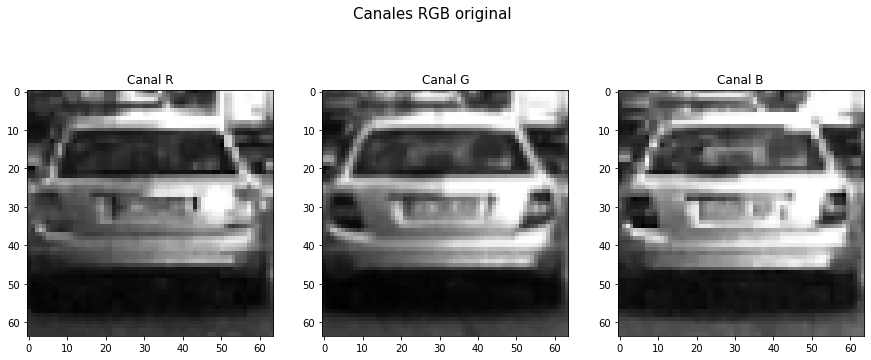

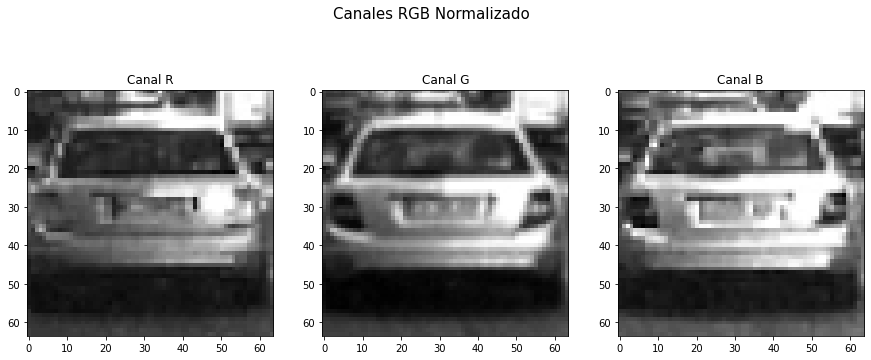

In [3]:
image_path = '145.png'
img_rgb = img_read('../data/vehicles/'+image_path)
img_norm = norm_image(img_rgb)

#Modelo RGB
img_R = img_rgb[:,:,0]
img_G = img_rgb[:,:,1]
img_B = img_rgb[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales RGB original', fontsize=15)
ax1.set_title('Canal R')
ax1.imshow(img_R, cmap='gray')
ax2.set_title('Canal G')
ax2.imshow(img_G, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')

#Modelo RGB
img_R = img_norm[:,:,0]
img_G = img_norm[:,:,1]
img_B = img_norm[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales RGB Normalizado', fontsize=15)
ax1.set_title('Canal R')
ax1.imshow(img_R, cmap='gray')
ax2.set_title('Canal G')
ax2.imshow(img_G, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')

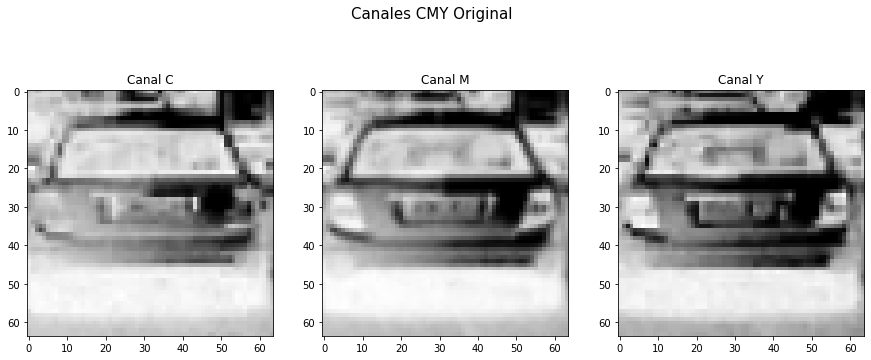

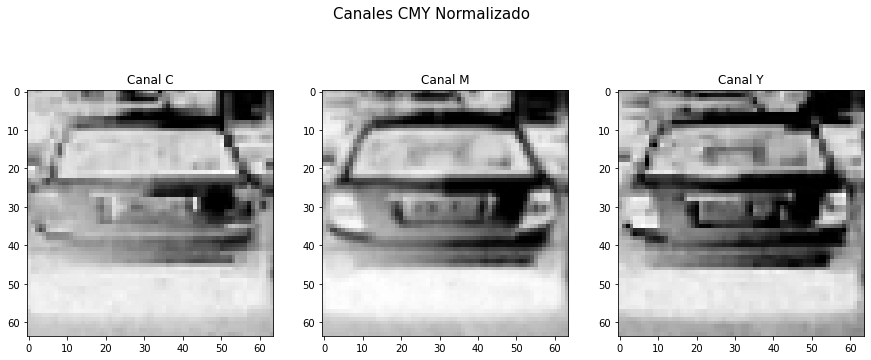

In [4]:
img_cmy = img_read('../data/vehicles/'+image_path)
img_cmy_norm = norm_image(img_cmy)

#Modelo CMY
img_C= 255 - img_cmy[:,:,0]
img_M = 255 - img_cmy[:,:,1]
img_Y = 255 - img_cmy[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales CMY Original', fontsize=15)
ax1.set_title('Canal C')
ax1.imshow(img_C, cmap='gray')
ax2.set_title('Canal M')
ax2.imshow(img_M, cmap='gray')
ax3.set_title('Canal Y')
ax3.imshow(img_Y, cmap='gray')

#Modelo CMY
img_C= 255 - img_cmy_norm[:,:,0]
img_M = 255 - img_cmy_norm[:,:,1]
img_Y = 255 - img_cmy_norm[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales CMY Normalizado', fontsize=15)
ax1.set_title('Canal C')
ax1.imshow(img_C, cmap='gray')
ax2.set_title('Canal M')
ax2.imshow(img_M, cmap='gray')
ax3.set_title('Canal Y')
ax3.imshow(img_Y, cmap='gray')

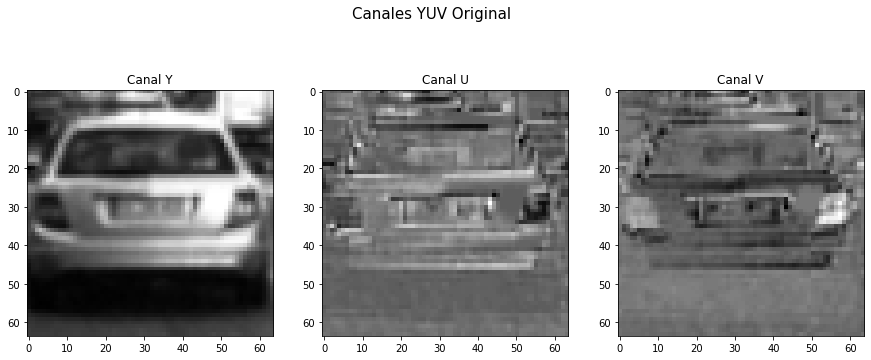

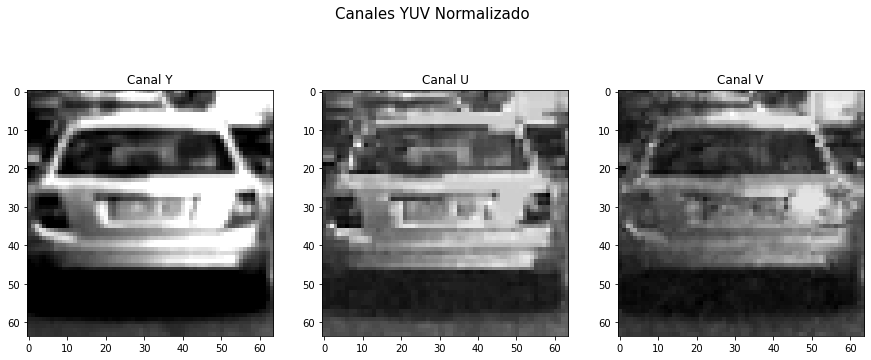

In [5]:
img_yuv = img_read('../data/vehicles/'+image_path, 'yuv')
img_yuv_norm = norm_image(img_yuv)

#Modelo YUV

img_Y = img_yuv[:,:,0]
img_U =  img_yuv[:,:,1]
img_V = img_yuv[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales YUV Original', fontsize=15)
ax1.set_title('Canal Y')
ax1.imshow(img_Y, cmap='gray')
ax2.set_title('Canal U')
ax2.imshow(img_U, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

#Modelo YUV

img_Y = img_yuv_norm[:,:,0]
img_U =  img_yuv_norm[:,:,1]
img_V = img_yuv_norm[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales YUV Normalizado', fontsize=15)
ax1.set_title('Canal Y')
ax1.imshow(img_Y, cmap='gray')
ax2.set_title('Canal U')
ax2.imshow(img_U, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

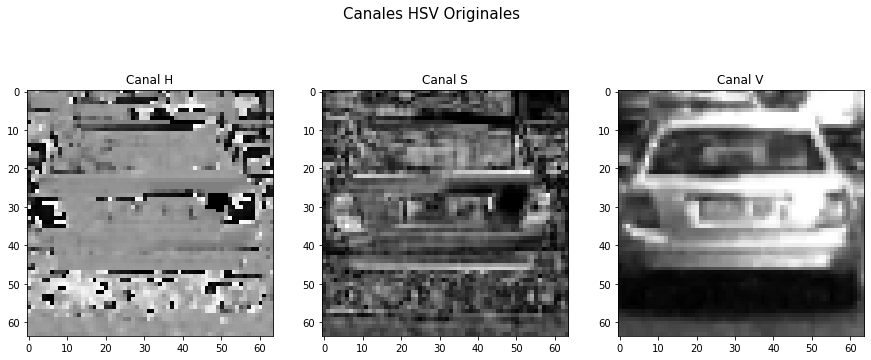

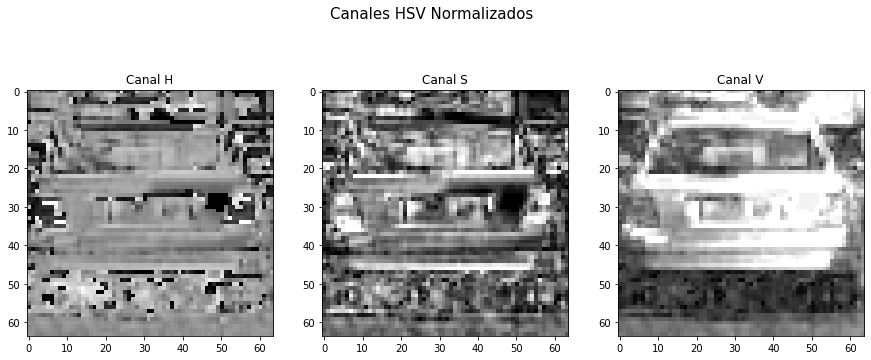

In [6]:
img_hsv = img_read('../data/vehicles/'+image_path, 'hsv')
img_hsv_norm = norm_image(img_hsv)

#Modelo HSV

img_H = img_hsv[:,:,0]
img_S =  img_hsv[:,:,1]
img_V = img_hsv[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales HSV Originales', fontsize=15)
ax1.set_title('Canal H')
ax1.imshow(img_H, cmap='gray')
ax2.set_title('Canal S')
ax2.imshow(img_S, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

#Modelo HSV

img_H = img_hsv_norm[:,:,0]
img_S =  img_hsv_norm[:,:,1]
img_V = img_hsv_norm[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales HSV Normalizados', fontsize=15)
ax1.set_title('Canal H')
ax1.imshow(img_H, cmap='gray')
ax2.set_title('Canal S')
ax2.imshow(img_S, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

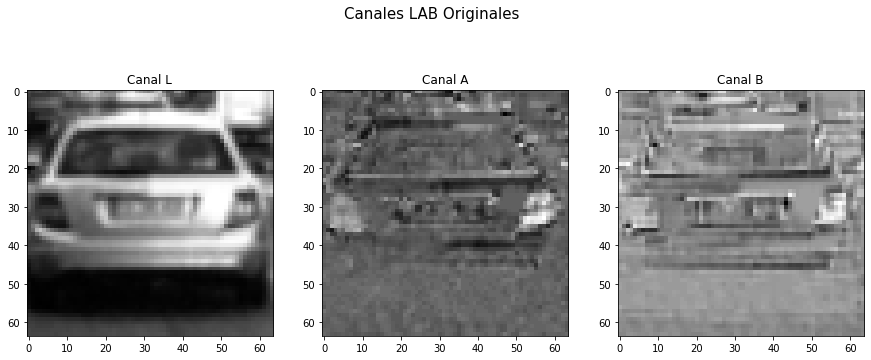

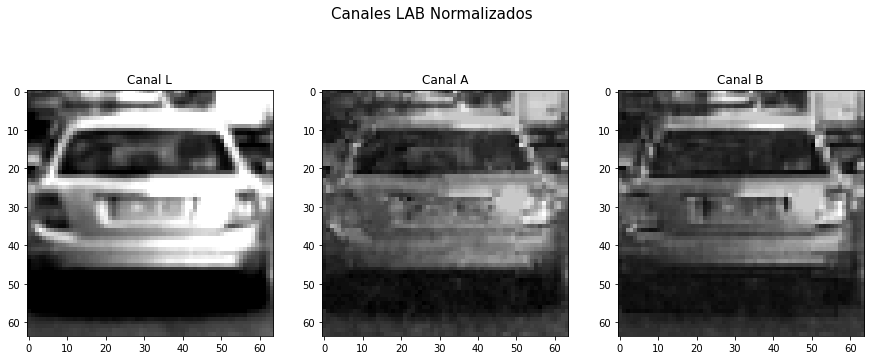

In [7]:
img_lab = img_read('../data/vehicles/'+image_path, 'lab')
img_lab_norm = norm_image(img_lab)

#Modelo LAB

img_L = img_lab[:,:,0]
img_A =  img_lab[:,:,1]
img_B = img_lab[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
fig.suptitle('Canales LAB Originales', fontsize=15)
ax1.set_title('Canal L')
ax1.imshow(img_L, cmap='gray')
ax2.set_title('Canal A')
ax2.imshow(img_A, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')

#Modelo LAB

img_L = img_lab_norm[:,:,0]
img_A =  img_lab_norm[:,:,1]
img_B = img_lab_norm[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
fig.suptitle('Canales LAB Normalizados', fontsize=15)
ax1.set_title('Canal L')
ax1.imshow(img_L, cmap='gray')
ax2.set_title('Canal A')
ax2.imshow(img_A, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')

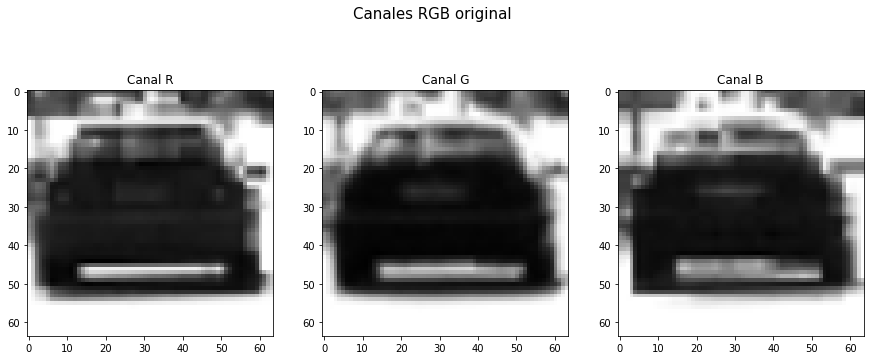

In [8]:
image_path_one = '50.png'
img_rgb = img_read('../data/vehicles/'+image_path_one)

#Modelo RGB
img_R = img_rgb[:,:,0]
img_G = img_rgb[:,:,1]
img_B = img_rgb[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales RGB original', fontsize=15)
ax1.set_title('Canal R')
ax1.imshow(img_R, cmap='gray')
ax2.set_title('Canal G')
ax2.imshow(img_G, cmap='gray')
ax3.set_title('Canal B')
ax3.imshow(img_B, cmap='gray')

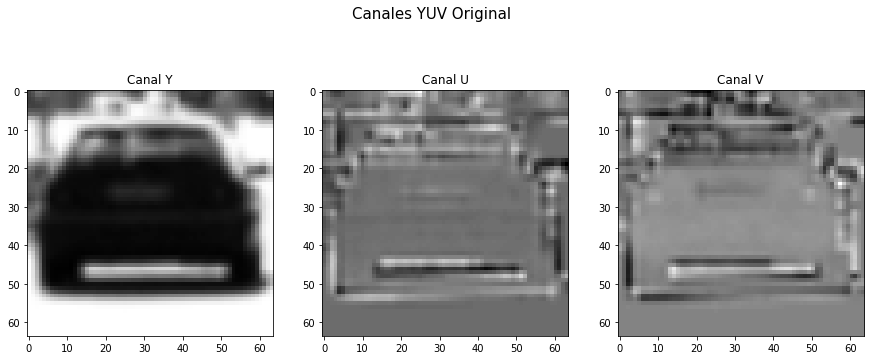

In [9]:
img_yuv = img_read('../data/vehicles/'+image_path_one, 'yuv')

#Modelo YUV

img_Y = img_yuv[:,:,0]
img_U =  img_yuv[:,:,1]
img_V = img_yuv[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales YUV Original', fontsize=15)
ax1.set_title('Canal Y')
ax1.imshow(img_Y, cmap='gray')
ax2.set_title('Canal U')
ax2.imshow(img_U, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

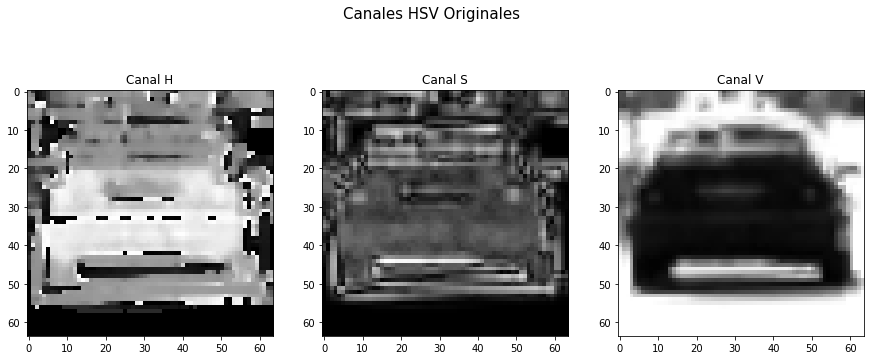

In [10]:
img_hsv = img_read('../data/vehicles/'+image_path_one, 'hsv')

#Modelo HSV

img_H = img_hsv[:,:,0]
img_S =  img_hsv[:,:,1]
img_V = img_hsv[:,:,2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))

fig.suptitle('Canales HSV Originales', fontsize=15)
ax1.set_title('Canal H')
ax1.imshow(img_H, cmap='gray')
ax2.set_title('Canal S')
ax2.imshow(img_S, cmap='gray')
ax3.set_title('Canal V')
ax3.imshow(img_V, cmap='gray')

### En esta prueba, los canales G(RGB) y Y(YUV) presentan el mayor contraste y muestran mejor el contorno del vehículo respecto al fondo. Se descartan los canales H y S del espectro HSV, pues el contorno del vehículo se mezcla con el fondo y no hay una distinción clara del objeto, al igual que los canales U y V del espectro YUV.

### A continuación se les aplica un kernel de acentuación a las imagenes en estos dos canales para ver si mejora su contraste y definición.

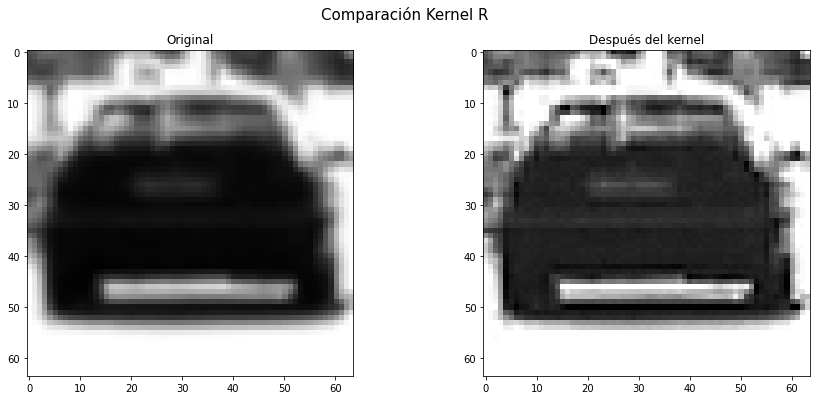

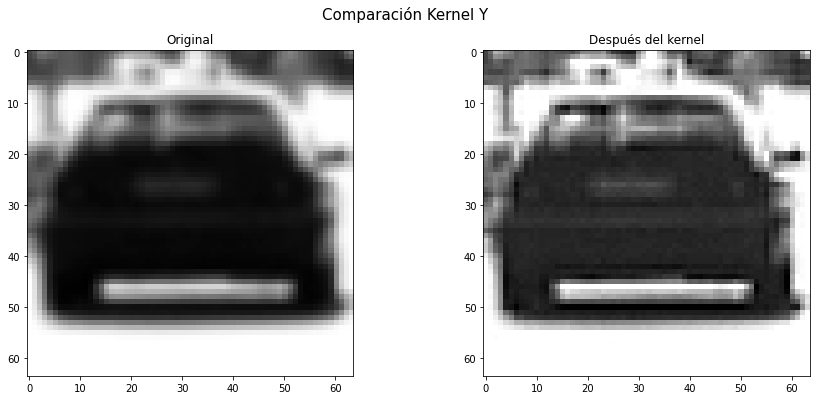

In [11]:
sharp_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
img_G_sharp = cv2.filter2D(img_G, -1, sharp_kernel)
img_Y_sharp = cv2.filter2D(img_Y, -1, sharp_kernel)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

fig.suptitle('Comparación Kernel R', fontsize=15)
ax1.set_title('Original')
ax1.imshow(img_G, cmap='gray')
ax2.set_title('Después del kernel')
ax2.imshow(img_G_sharp, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))

fig.suptitle('Comparación Kernel Y', fontsize=15)
ax1.set_title('Original')
ax1.imshow(img_Y, cmap='gray')
ax2.set_title('Después del kernel')
ax2.imshow(img_Y_sharp, cmap='gray')

#### Al aplicar el kernel de acentuación, se resaltan detalles que pueden ayudar a distinguir el auto, como la matrícula y las luces o reflectores. 


#### Se encierra esta funcionalidad bajo una función para su posterior uso.

## Ecualizacion de la imagen

<Figure size 432x288 with 0 Axes>

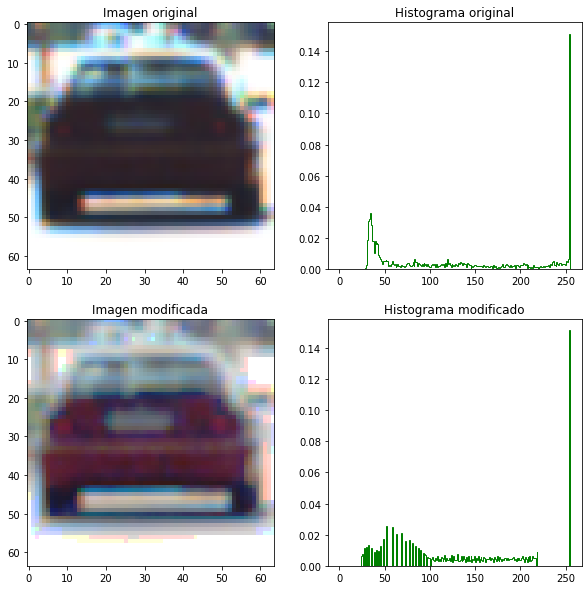

In [12]:
#Definir la función ecualización del histograma cuyo parámetro es una imagen
img_rgb1 = img_read('../data/vehicles/'+image_path_one)
#Modelo RGB
img_G2 = img_rgb1

#Leer la imagen y aplicar la transformación ecualización del histograma sobre ésta

res_ecua = histogram_equalization(img_G2)

#Generar subplot 2x3 para mostrar imagen histograma y función de densidad acumulada
fig, arreglo_plots = plt.subplots(2,2 ,figsize=(10 ,10))
colors = ('r','g','b')

arreglo_plots[0,0].set_title('Imagen original')
arreglo_plots[0,0].imshow(img_G2, cmap='gray')
arreglo_plots[0,1].set_title('Histograma original')
img_array_i = img_G.ravel()
_=arreglo_plots[0,1].hist(img_array_i,histtype='step', bins=255 ,
                            range=(0.0, 255.0),density=True ,color=colors[1])

arreglo_plots[1,0].set_title('Imagen modificada')
arreglo_plots[1,0].imshow(res_ecua, cmap="gray")
arreglo_plots[1,1].set_title('Histograma modificado')
img_array_i = res_ecua.ravel()
_=arreglo_plots[1,1].hist(img_array_i,histtype='step', bins=255,
                          range=(0.0, 255.0),density=True, color=colors[1])

<Figure size 432x288 with 0 Axes>

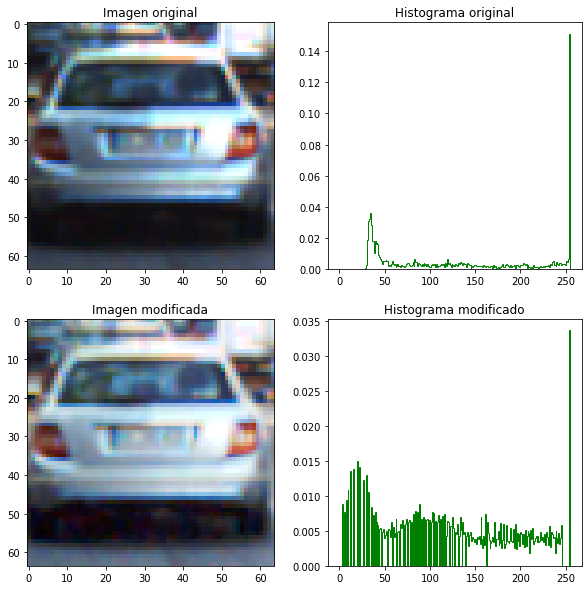

In [33]:
image_path = "145.png"
#Definir la función ecualización del histograma cuyo parámetro es una imagen
img_rgb1 = img_read('../data/vehicles/'+image_path)
#Modelo RGB
img_G2 = img_rgb1

#Leer la imagen y aplicar la transformación ecualización del histograma sobre ésta

res_ecua2 = histogram_equalization(img_G2)

#Generar subplot 2x3 para mostrar imagen histograma y función de densidad acumulada
fig, arreglo_plots = plt.subplots(2,2 ,figsize=(10 ,10))
colors = ('r','g','b')

arreglo_plots[0,0].set_title('Imagen original')
arreglo_plots[0,0].imshow(img_G2, cmap='gray')
arreglo_plots[0,1].set_title('Histograma original')
img_array_i = img_G.ravel()
_=arreglo_plots[0,1].hist(img_array_i,histtype='step', bins=255 ,
                            range=(0.0, 255.0),density=True ,color=colors[1])

arreglo_plots[1,0].set_title('Imagen modificada')
arreglo_plots[1,0].imshow(res_ecua2, cmap="gray")
arreglo_plots[1,1].set_title('Histograma modificado')
img_array_i = res_ecua2.ravel()
_=arreglo_plots[1,1].hist(img_array_i,histtype='step', bins=255,
                          range=(0.0, 255.0),density=True, color=colors[1])

## Filtro Gaussiano

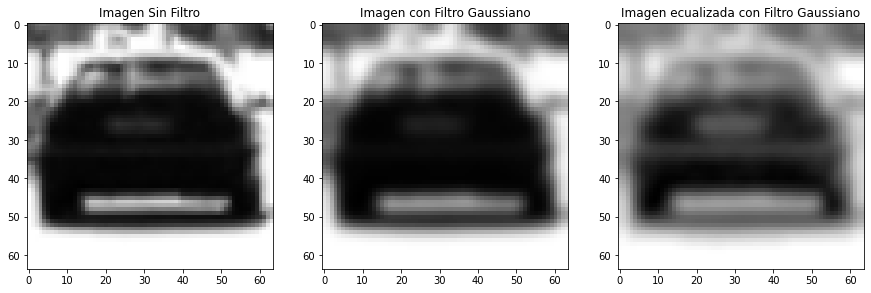

In [28]:
res_gauss = cv2.GaussianBlur(img_G2,(5, 5),2)
res_gauss_ecua= cv2.GaussianBlur(res_ecua2,(5, 5),2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con Filtro Gaussiano")
ax2.imshow(res_gauss)
ax3.set_title("Imagen ecualizada con Filtro Gaussiano")
ax3.imshow(res_gauss_ecua)

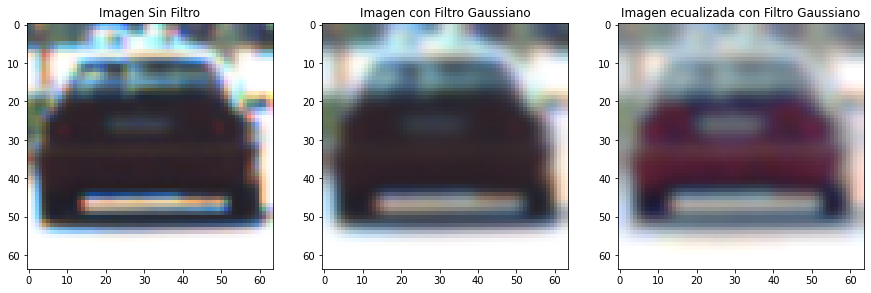

In [15]:
img_rgb1 = img_read('../data/vehicles/'+image_path_one)
#Modelo RGB
img_G2 = img_rgb1

res_gauss = cv2.GaussianBlur(img_G2,(5, 5),2)
res_gauss_ecua= cv2.GaussianBlur(res_ecua,(5, 5),2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con Filtro Gaussiano")
ax2.imshow(res_gauss)
ax3.set_title("Imagen ecualizada con Filtro Gaussiano")
ax3.imshow(res_gauss_ecua)

## Filtro de Media 

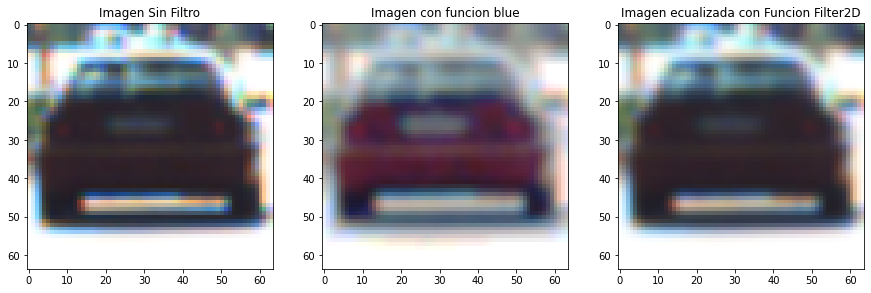

In [16]:
k_size=3 #valor tamaño del kernel
#CANAL G - RGB
fmb_imagen5,fmd_imagen5 = filtro_mediab(res_ecua,k_size),filtro_media2d(img_G2,k_size) 
#solo se mostro el filtro en la imagen 5

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con funcion blue")
ax2.imshow(fmb_imagen5)
ax3.set_title("Imagen ecualizada con Funcion Filter2D")
ax3.imshow(fmd_imagen5)


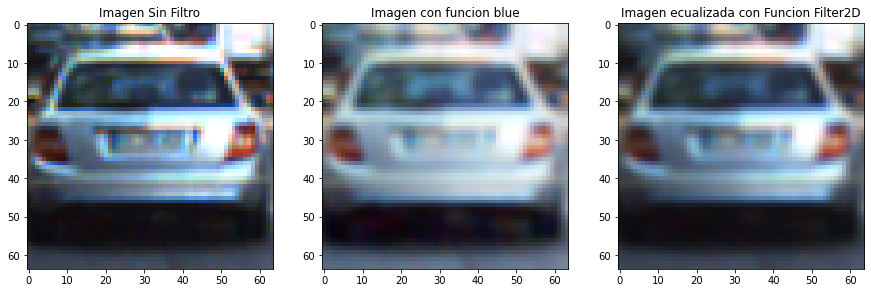

In [17]:
k_size=3#valor tamaño del kernel

img_rgb1 = img_read('../data/vehicles/'+image_path)
#Modelo RGB
img_G2 = img_rgb1

#CANAL G - RGB
fmb_imagen5,fmd_imagen5 = filtro_mediab(res_ecua2,k_size),filtro_media2d(img_G2,k_size) 
#solo se mostro el filtro en la imagen 5

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con funcion blue")
ax2.imshow(fmb_imagen5)
ax3.set_title("Imagen ecualizada con Funcion Filter2D")
ax3.imshow(fmd_imagen5)


## Filtro mediana

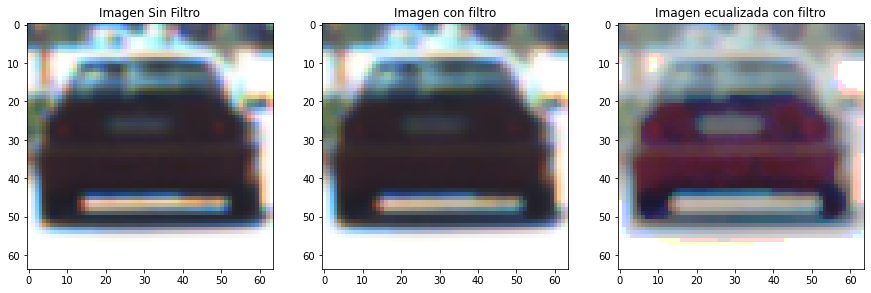

In [18]:
#Definir tamaño del kernel
k_size = 3

img_rgb1 = img_read('../data/vehicles/'+image_path_one)
#Modelo RGB
img_G2 = img_rgb1

res1 = cv2.medianBlur(img_G2, k_size)
res2 = cv2.medianBlur(res_ecua, k_size)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con filtro")
ax2.imshow(res1)
ax3.set_title("Imagen ecualizada con filtro")
ax3.imshow(res2)


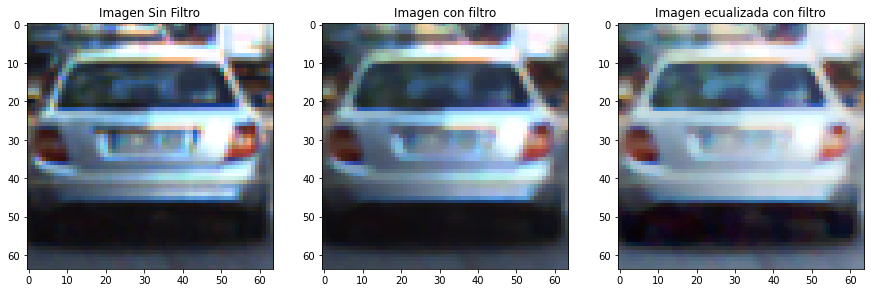

In [19]:
#Definir tamaño del kernel
k_size = 3

img_rgb1 = img_read('../data/vehicles/'+image_path)
#Modelo RGB
img_G2 = img_rgb1

res1 = cv2.medianBlur(img_G2, k_size)
res2 = cv2.medianBlur(res_ecua2, k_size)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
ax1.set_title("Imagen Sin Filtro")
ax1.imshow(img_G2)
ax2.set_title("Imagen con filtro")
ax2.imshow(res1)
ax3.set_title("Imagen ecualizada con filtro")
ax3.imshow(res2)


## Filtro Minimo 

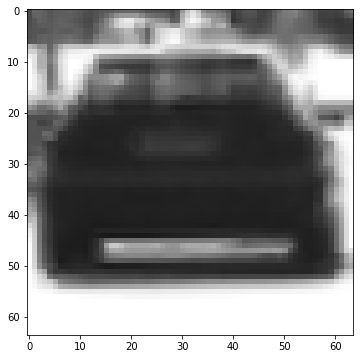

In [20]:
k_size = 1

img_rgb1 = img_read('../data/vehicles/'+image_path_one)
#Modelo RGB
img_G2 = img_rgb1

fig, (ax1) = plt.subplots(1, figsize=(15, 6))
ax1.imshow(minimum_filter(img_rgb1, k_size))

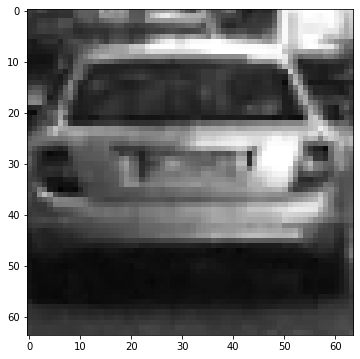

In [21]:
k_size = 1

img_rgb1 = img_read('../data/vehicles/'+image_path)
#Modelo RGB
img_G2 = img_rgb1

fig, (ax1) = plt.subplots(1, figsize=(15, 6))
ax1.imshow(minimum_filter(img_rgb1, k_size))

## Filtro Maximo

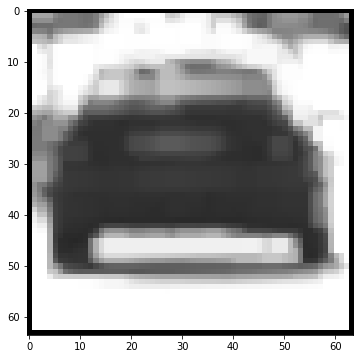

In [22]:
k_size = 2

img_rgb1 = img_read('../data/vehicles/'+image_path_one)
#Modelo RGB
img_G2 = img_rgb1

fig, (ax1) = plt.subplots(1, figsize=(15, 6))
ax1.imshow(maximum_filter(img_rgb1, k_size))

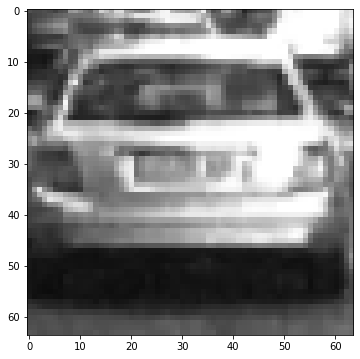

In [23]:
k_size = 1

img_rgb1 = img_read('../data/vehicles/'+image_path)
#Modelo RGB
img_G2 = img_rgb1

fig, (ax1) = plt.subplots(1, figsize=(15, 6))
ax1.imshow(maximum_filter(img_rgb1, k_size))